In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
%matplotlib inline

## **The data:
    This data set came from the Urban Rate Survey (broadband) 2018, an annual survey taken by the FCC regarding broadband (non-mobile) plans and pricing. The data will be used to determine ways in which these access barriers can be lowered.
    The term "Speed" throughout this notebook refers to download bandwidth measured in Mbps.**

# Data set exploration:

In [2]:
df = pd.read_csv('broadband.csv')
#Take a look at the data
print(df.columns)
print(df.dtypes)

Index(['Provider', 'State', 'Weight', 'Technology', 'Download Bandwidth Mbps',
       'Upload Bandwidth Mbps', 'Usage Allowance GB', 'Monthly Charge',
       'Other Mandatory Charge', 'Surcharge', 'Total Charge',
       'Total Charge Spread', 'Model Data'],
      dtype='object')
Provider                    object
State                       object
Weight                     float64
Technology                  object
Download Bandwidth Mbps    float64
Upload Bandwidth Mbps      float64
Usage Allowance GB          object
Monthly Charge             float64
Other Mandatory Charge     float64
Surcharge                  float64
Total Charge               float64
Total Charge Spread        float64
Model Data                  object
dtype: object


In [3]:
# remove space in the column names and set all to lower(), for ease
df.columns = df.columns.str.replace('\s*','')
df.columns = df.columns.str.lower()


In [4]:
#Explore the data
print(df.totalcharge.mean())
print(df.provider.value_counts().head(5))
print(df.groupby('provider')['totalcharge'].mean().head(5))
print(df.groupby('state')['totalcharge'].mean().head(10))
print(df.groupby('state')['totalcharge'].mean().mean())

79.90299339934056
Charter Communications, Inc.             302
CenturyLink, Inc.                        245
Cincinnati Bell Telephone Company LLC    207
Suddenlink Communications                177
AT&T Services, Inc.                      176
Name: provider, dtype: int64
provider
3 Rooms Communications LLC                     44.990000
ALASKA COMMUNICATIONS SYSTEMS HOLDING, INC.    79.990000
AMA Communications, L.L.C.                     59.900000
AT&T Services, Inc.                            60.857955
Ace Telephone Company of Michigan Inc          58.700000
Name: totalcharge, dtype: float64
state
ALABAMA                  71.462353
ALASKA                   92.440690
ARIZONA                  80.525217
ARKANSAS                 78.181818
CALIFORNIA               89.057547
COLORADO                 83.684194
CONNECTICUT              68.976111
DELAWARE                109.990000
DISTRICT OF COLUMBIA    111.490000
FLORIDA                  65.750482
Name: totalcharge, dtype: float64
78.6836798

In [5]:
df['totalcharge'].describe()

count    3030.000000
mean       79.902993
std        47.725710
min        14.950000
25%        52.130000
50%        69.950000
75%        98.990000
max       605.000000
Name: totalcharge, dtype: float64

So far it looks like the simple average across all plans is around $80 per month.
Next, some visualizations

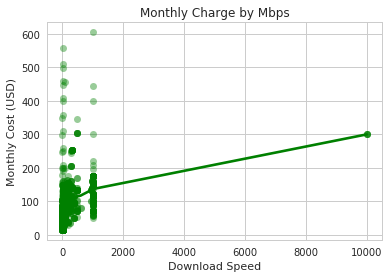

In [6]:
sns.set(style='whitegrid',palette='dark')
f = sns.regplot(x='downloadbandwidthmbps',
               y='totalcharge',
               data=df,
               color='green',
               lowess=True,
               scatter_kws={'alpha':.4})
plt.xlabel('Download Speed')
plt.ylabel('Monthly Cost (USD)')
plt.title("Monthly Charge by Mbps")
plt.show()

There appear to be outliers that skew the visualization. How many instances? Can they be dropped?


In [7]:
print(df.loc[df.downloadbandwidthmbps == max(df.downloadbandwidthmbps)][['provider', 'state', 'downloadbandwidthmbps']])
state_providers  = df.groupby('state')['provider'].value_counts() #not quite what i wanted
state_provider_count = state_providers.groupby('state').describe()[['count']] #what i wanted


              provider      state  downloadbandwidthmbps
1608  EPB Fiber Optics  TENNESSEE                10000.0
1611  EPB Fiber Optics  TENNESSEE                10000.0
1615  EPB Fiber Optics  TENNESSEE                10000.0
1616  EPB Fiber Optics  TENNESSEE                10000.0


Only 4 instances, but maybe they represent a unique ISP in the state.

In [8]:
print(df.loc[df['state']=='TENNESSEE']['provider'].value_counts())

TDS TELECOMMUNICATIONS CORPORATION      27
EPB Fiber Optics                        12
Charter Communications, Inc.             6
BRISTOL TENNESSEE ESSENTIAL SERVICES     6
COMCAST CABLE COMMUNICATIONS, LLC        5
Name: provider, dtype: int64


Dropping these 4 instances will not affect the number of ISPs in Tennessee.

In [9]:
#Drop the 4 instances of 10000Mbps
df = df.loc[df['downloadbandwidthmbps'] != 10000]

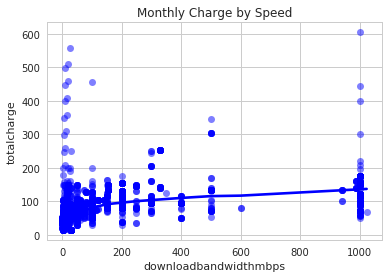

In [10]:
#Visualize the same data
sns.set(style='whitegrid',palette='muted')
f = sns.regplot(x='downloadbandwidthmbps',
               y='totalcharge',
               data=df,
               color='blue',
               lowess=True,
               scatter_kws={'alpha':.5})
plt.title("Monthly Charge by Speed")
plt.show()

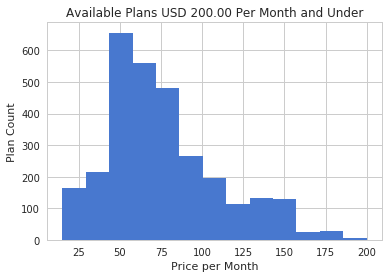

In [11]:
# Distribution of Prices USD 200 or less per month
less_than_200 = df.loc[df['totalcharge']<=200]
plt.hist(less_than_200['totalcharge'], bins=13)
plt.ylabel('Plan Count')
plt.xlabel('Price per Month')
plt.title('Available Plans USD 200.00 Per Month and Under')
plt.show()

These visualizations are better, however there still seems to be some segmentation by download speed. 
Also, there are some costly plans where the speeds are very slow.  

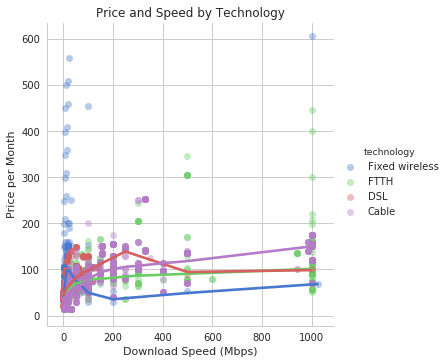

In [12]:
#Plot the same data separated by Technology
sns.set_style('whitegrid')
sns.lmplot(x='downloadbandwidthmbps',
           y='totalcharge',
           hue='technology',
           data=df,
           lowess=True,
           scatter_kws={'alpha':.4})
plt.ylabel("Price per Month")
plt.xlabel("Download Speed (Mbps)")
plt.title('Price and Speed by Technology')
plt.show()

This visualization is helpful in identifying that 'Fixed wireless' technology could skew our results. After some preliminary research and provider identification it appears that these 'extreme' prices for relatively slow speeds are due to lack of infrastructure in rural areas.
#http://www.getunwired.com/ & https://www.pogozone.com/
Fixed wireless will be removed from the analysis, as specialized ISPs for rural areas are outside of the scope of this experiment.


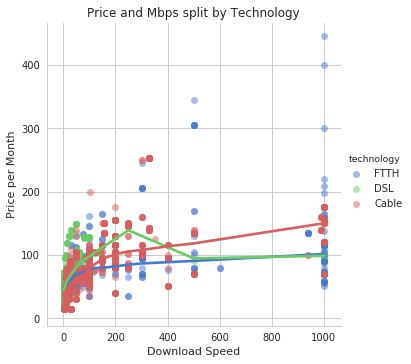

In [13]:
#Remove fixed wireless, replot the same data
df = df.loc[df['technology'] != 'Fixed wireless']
sns.set_style('whitegrid')
sns.lmplot(x='downloadbandwidthmbps',
           y='totalcharge',
           hue='technology',
           data=df,
           lowess=True,
           scatter_kws={'alpha':.5})
plt.ylabel("Price per Month")
plt.xlabel("Download Speed")
plt.title('Price and Mbps split by Technology')
plt.show()

There appears to be a bit of segmentation along the speed access. For this analysis, the broadband plans will separated into 3 tiers based on their speed: 200Mbps or slower, between 200 and 500Mbps, and than 500 of faster.

In [14]:
#create function to label each entry by "speed tier"
def label_tier (row):
    if row['downloadbandwidthmbps'] <= 200 :
        return '200Mbps or Less'
    if row['downloadbandwidthmbps'] <=500 :
        return '200-500Mbps'
    if row['downloadbandwidthmbps'] > 500:
        return 'Over 500 Mbps'

In [15]:
#apply label_tier
df['speedtier'] = df.apply (lambda row: label_tier (row),axis=1)

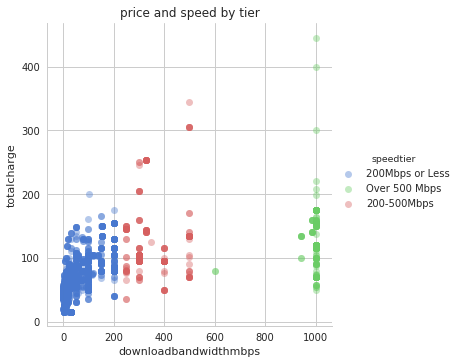

In [16]:
#verify with visualization
g = sns.lmplot(x='downloadbandwidthmbps',
               y='totalcharge',
               hue='speedtier',
               data=df,
               fit_reg=False,
               scatter_kws={'alpha':.4})
              
plt.title('price and speed by tier')
plt.show()

A look at each tier individually

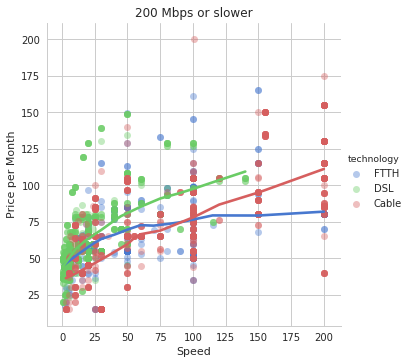

In [17]:
#200 Mbps or lower

sns.lmplot(x='downloadbandwidthmbps',
           y='totalcharge',
           hue='technology',
           data=df.loc[df['speedtier'] == '200Mbps or Less'],
           lowess=True,
           scatter_kws={'alpha':.4})
plt.xlabel('Speed')
plt.ylabel('Price per Month')
plt.title('200 Mbps or slower')
plt.show()

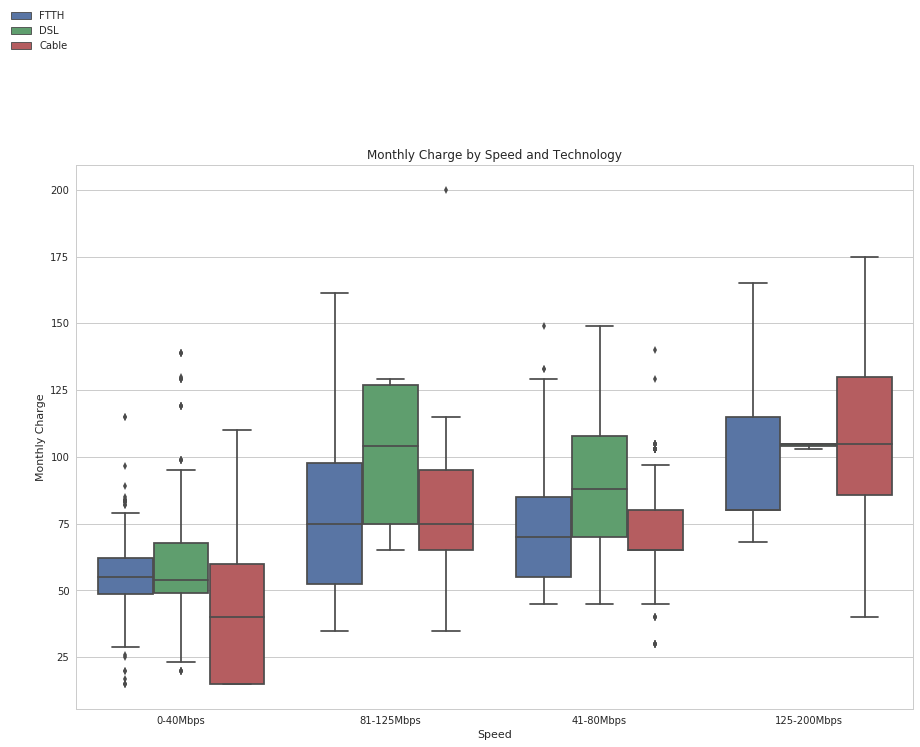

In [18]:
#The graph above would look better as a box plot and more insight could be gained by separating the speeds again.
#Less than 200Mbps or less DF
tier3 = pd.DataFrame(df.loc[df['speedtier'] == '200Mbps or Less'])

def label_subtier (row):
    if row['downloadbandwidthmbps'] <= 40 :
        return '0-40Mbps'
    if row['downloadbandwidthmbps'] <=80 :
        return '41-80Mbps'
    if row['downloadbandwidthmbps'] <= 125:
        return '81-125Mbps'
    if row['downloadbandwidthmbps'] >125:
        return "125-200Mbps"

tier3['subtier'] = tier3.apply (lambda row: label_subtier (row),axis=1)
#Box plot to represent the speedtier of 200 Mbps or slower
sns.set(style='whitegrid', font_scale=1)
plt.figure(figsize=(15,10))
g = sns.boxplot(x=tier3['subtier'], y=tier3['totalcharge'], hue=tier3['technology'], data=tier3)
plt.title('Monthly Charge by Speed and Technology')
plt.xlabel('Speed')
plt.ylabel('Monthly Charge')
g.legend(bbox_to_anchor=(0,1.3))
plt.show()            
                            

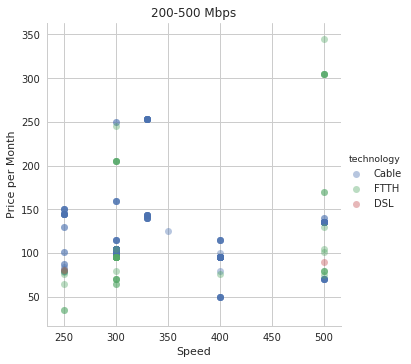

In [19]:
#Between 200 and 500 Mbps
sns.lmplot(x='downloadbandwidthmbps',
           y='totalcharge',
           hue='technology',
           data=df.loc[df['speedtier'] == '200-500Mbps'],
           fit_reg=False,
           scatter_kws={'alpha':.4})
plt.xlabel('Speed')
plt.ylabel('Price per Month')
plt.title('200-500 Mbps')
plt.show()

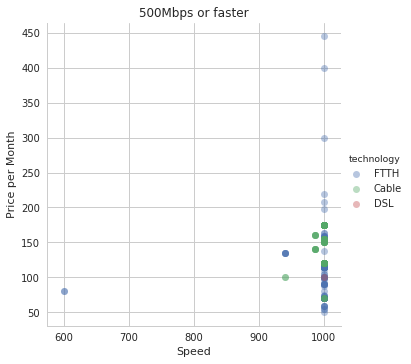

In [20]:
#500 Mbps or faster
sns.lmplot(x='downloadbandwidthmbps',
           y='totalcharge',
           hue='technology',
           data=df.loc[df['speedtier'] == 'Over 500 Mbps'],
           fit_reg=False,
           scatter_kws={'alpha':.4})
plt.xlabel('Speed')
plt.ylabel('Price per Month')
plt.title('500Mbps or faster')
plt.show()

## So far, visualizations based on price, technology, and speed has lead to cleaner data. The data suggests that as the bandwidth or speed increases, so does the price. One idea would be to just have lower speeds for everyone, therefor bring the price down as well. However, the objective is to maximize the service while reducing cost. Next, the data will grouped by state and analyzed. The goal is to analyse the cost of access in terms of ISPs per state.

In [21]:
#creating some agg level dataframes
state_providers  = df.groupby('state')['provider'].value_counts() #not quite what i wanted
state_provider_count = state_providers.groupby('state').describe().reset_index()[['state','count']] #what i wanted
print(state_providers.head(10))
print(state_provider_count.head(10))

state    provider                                   
ALABAMA  Cable One, Inc.                                 7
         Wiregrass Telcom, Inc.                          4
         Charter Communications, Inc.                    3
         Knology of Alabama, Inc.                        3
ALASKA   GCI Communication Corp.                        40
         ALASKA COMMUNICATIONS SYSTEMS HOLDING, INC.    14
ARIZONA  CenturyLink, Inc.                              22
         Suddenlink Communications                      18
         Cox Communications                             13
         Cable One, Inc.                                 7
Name: provider, dtype: int64
                  state  count
0               ALABAMA    4.0
1                ALASKA    2.0
2               ARIZONA    5.0
3              ARKANSAS    1.0
4            CALIFORNIA   12.0
5              COLORADO    4.0
6           CONNECTICUT    2.0
7              DELAWARE    1.0
8  DISTRICT OF COLUMBIA    1.0
9               FL

# Analysis that highlights the experimental hypothesis:

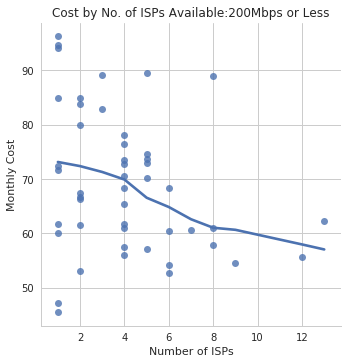

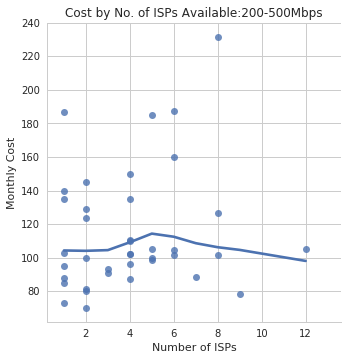

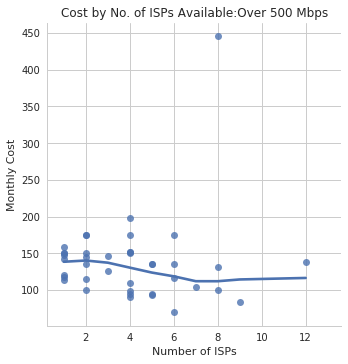

In [22]:
#Get mean monthly price for each speed tier
cost200 = df.loc[df['speedtier'] == '200Mbps or Less'].groupby('state')['totalcharge'].mean().reset_index()
cost200500 = df.loc[df['speedtier'] == '200-500Mbps'].groupby('state')['totalcharge'].mean().reset_index()
cost500 = df.loc[df['speedtier'] == 'Over 500 Mbps'].groupby('state')['totalcharge'].mean().reset_index()
#Create a new DataFrame with 'ispcount' and the mean price for each speed tier
dfplot1 = pd.DataFrame()
dfplot1['ispcount'] = state_provider_count['count']
dfplot1['cost3'] = cost200.totalcharge
dfplot1['cost2'] = cost200500.totalcharge
dfplot1['cost1'] = cost500.totalcharge

slow = sns.lmplot(x='ispcount',
                  y='cost3',
                  data=dfplot1,
                  lowess=True)
plt.xlabel('Number of ISPs')
plt.ylabel('Monthly Cost')
plt.title('Cost by No. of ISPs Available:200Mbps or Less')
plt.show()

normal = sns.lmplot(x='ispcount',
                    y='cost2',
                    data=dfplot1,
                    lowess=True)
plt.xlabel('Number of ISPs')
plt.ylabel('Monthly Cost')
plt.title('Cost by No. of ISPs Available:200-500Mbps')
plt.show()

fast = sns.lmplot(x='ispcount',
                  y='cost1',
                  data=dfplot1,
                  lowess=True)
plt.xlabel('Number of ISPs')
plt.ylabel('Monthly Cost')
plt.title('Cost by No. of ISPs Available:Over 500 Mbps')
plt.show()


After visualizing each speed tier by the number of ISPs available by state,  it appears that the cost for internet access is less expensive for those who have more ISP optins relative those who have fewer options.


In [23]:
print(df['speedtier'].value_counts())
print("{}% 200 Mbps or slower".format(str(round(2126/len(df.speedtier)*100,2))))



200Mbps or Less    2126
200-500Mbps         270
Over 500 Mbps       220
Name: speedtier, dtype: int64
81.27% 200 Mbps or slower


As the group with speeds of 200Mbps or slower make up more than 80% of data, this is the group that will be analyzed.

In [24]:
#The mean price for those with 5 ISPs or fewer
print("Mean Price for 5 ISPs or fewer = ""%.2f" % dfplot1[dfplot1.ispcount<=5].cost3.mean())
#The mean price for those with more than 5 ISPs
print("Mean Price for more than 5 ISPs = ""%.2f" % dfplot1[dfplot1.ispcount>5].cost3.mean())
print('Can we say that internet is less expensive on average for those who have more than 5 ISPs?')
print(ss.ttest_ind(dfplot1[dfplot1.ispcount<=5].cost3,
                dfplot1[dfplot1.ispcount>5].cost3))

Mean Price for 5 ISPs or fewer = 71.47
Mean Price for more than 5 ISPs = 61.51
Can we say that internet is less expensive on average for those who have more than 5 ISPs?
Ttest_indResult(statistic=2.3430491681223087, pvalue=0.02350644392302339)


# Experimental Hypothesis:

**One way to lower the price of access to the internet is to increase the number of ISPs in the marketplace.**

# The Rollout Plan:

Two states would be chosen for this A/B experiment. Of these two states, three (large) metropolitan areas would be selected. Ex (San Diego, Los Angeles, and San Francisco, Houston, Dallas, Austin) In one state, no government action would be taken regarding the number of ISPs. This would be the control version. In the other state, or B version, heavy government intervention to incentivize new ISPs would be introduced. The FCC would also be petitioned to set up an API so data could be collected more efficiently.

The sample would be survey respondents living the areas of the experiment, similar to the Urban Rate Survey, however the aim would be collect a larger number of samples in order reduce the variance.

The mean price in each metropolitan area will be observed at the start of the experiment and 3 years after.

**The null hypothesis:**

The price of internet in the treatment group will stay the same.

**The alternative hypothesis:**

The price internet will decrease in the treatment group by a larger amount than the control group.

# Evaulation Plan

After 3 years, (given the increase in ISPs) the mean price of internet in the test group should have decreased. If the price of internet in the control group also decreased, the price in the test group should decrease by a greater amount than the control group.

The key metric in the experiment is price per month for access to the internet. However, several other metrics would be measured as well. Metrics such as number of ISPs, download speeds, data usage restrictions, and new subscriptions could help evaluate the nature of the price movement.

If the price decrease in the treatment group is more than in the control group, this type of intervention could be used in other locations to bring down the cost of internet as well.
